<a href="https://colab.research.google.com/github/sk48880/AV-WNS-Analytics-wizard-2019/blob/master/WNS_Analytics_Wizard_Click_through_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

The task is to predict click probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.

#### Evaluation Metric
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Key points
- The E-commerce company sells multiple products on its platform
User behavior is recorded in the logs
- View log of users is for around 22 days (15th Oct 2018 - 5th Nov 2018)
- Train data has the impression logs for 29 days (15th Nov 2018 – 13th Dec 2018) along with the label which specifies whether the ad is clicked or not
- Test data have impression logs for 7 days (12th Dec 2018 – 18th Dec 2018) without the labels
- 12th and 13th Dec are overlap between train and test dataset. We can put a lookup to see if the user_id matches then, for those we can input the values
- The product description is collected from the Zbay website

## Load Libraries

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import datetime

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Load Dataset

In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 6.6MB/s 


In [4]:
link = 'https://drive.google.com/open?id=1tL9tqvUsClU7pCH8d-nvjfzmVZOdBuCh' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  

link = 'https://drive.google.com/open?id=165F9lJJJYSPB4yGWyQjDMWCudQHSyTxB' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  

link = 'https://drive.google.com/open?id=1cXIyr5cdNvc3u36qCjIhtNjTPjv4lDJc' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('sample_submission.csv')  

link = 'https://drive.google.com/open?id=1jym6T5H3-TLaz3m1XZ7tA_SIDNIok96d' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('item_data.csv')  

link = 'https://drive.google.com/open?id=1PfXH8UF3jqqAbO-s3LsHtZy1MsFHglyC' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('view_log.csv')  

1tL9tqvUsClU7pCH8d-nvjfzmVZOdBuCh
165F9lJJJYSPB4yGWyQjDMWCudQHSyTxB
1cXIyr5cdNvc3u36qCjIhtNjTPjv4lDJc
1jym6T5H3-TLaz3m1XZ7tA_SIDNIok96d
1PfXH8UF3jqqAbO-s3LsHtZy1MsFHglyC


In [0]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
item = pd.read_csv('/content/item_data.csv')
log = pd.read_csv('/content/view_log.csv')

## Data Exploration

In [8]:
train.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


In [9]:
log.head(3)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855


In [10]:
item.head(2)

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822


In [14]:
print("shape of train data",train.shape)
print("===============================")
print("shape of log data",log.shape)
print("===============================")
print("shape of item data",item.shape)
print("===============================")
print("shape of train data",test.shape)

shape of train data (237609, 7)
shape of log data (3118622, 5)
shape of item data (132761, 6)
shape of train data (90675, 6)


### Variable Types
- impression_id : Id can be ignored (which ad is driving more clicks) -237609 unique ads
- user_id : Id can be ignored (Is a repetitive users who isn't clicking for a particular item? or, is there any user who is always clicking but not buying an item?) - 74723 unique users
- session_id : Id can be ignored
- item_id : Id can be ignored (which item is getting more clicks?) - 126708 unique products
- app_code : Categorical (490 categories) - publisher id (which publisher is driving more traffic?)

-----------------------------------------------------------------------
- impression_time : DateTime - Can be used for Day of week, Time of day analysis
- os_version : Categorical (3 categories)
- is_4G : Categorical (2 categories)
- server_time : Timestamp of the log
- device_type : Categorical (3 categories)
- item_price : Continuous (Numerical)
- category_1 : Categorical (17 categories)
- category_2 : Categorical (79 categories)
- category_3 : Categorical (335 categories)
- product_type : Categorical (7959 categories)
- is_click : Categorical (Target Variable)
### Can be ignored
- impression_id : Id can be ignored
- user_id : Id can be ignored
- session_id : Id can be ignored
- item_id : Id can be ignored
- app_code : Categorical (490 categories) - publisher id - It would have be better if publisher category was given rather than publisher id

In [15]:
print("Number of categories in app_code")
print(train["app_code"].nunique())
print("==================================================================")
print("Number of categories in os_version")
print(train["os_version"].nunique())
print("==================================================================")
print("Number of categories in is_4G")
print(train["is_4G"].nunique())
print("==================================================================")
print("Number of categories in device_type")
print(log["device_type"].nunique())
print("==================================================================")
print("Number of categories in category_1")
print(item["category_1"].nunique())
print("==================================================================")
print("Number of categories in category_2")
print(item["category_2"].nunique())
print("==================================================================")
print("Number of categories in category_3")
print(item["category_3"].nunique())
print("==================================================================")
print("Number of categories in product_type")
print(item["product_type"].nunique())
print("==================================================================")
print("Number of categories in impression_id")
print(train["impression_id"].nunique())
print("==================================================================")
print("Number of categories in user_id")
print(train["user_id"].nunique())
print("==================================================================")
print("Number of categories in item_id")
print(log["item_id"].nunique())

Number of categories in app_code
490
Number of categories in os_version
3
Number of categories in is_4G
2
Number of categories in device_type
3
Number of categories in category_1
17
Number of categories in category_2
79
Number of categories in category_3
335
Number of categories in product_type
7959
Number of categories in impression_id
237609
Number of categories in user_id
74723
Number of categories in item_id
126708


In [16]:
print("Categories in os_version")
print(train["os_version"].unique())
print("==================================================================")
print("Categories in is_4G")
print(train["is_4G"].unique())
print("==================================================================")
print("Categories in device_type")
print(log["device_type"].unique())

Categories in os_version
['old' 'latest' 'intermediate']
Categories in is_4G
[0 1]
Categories in device_type
['android' 'iphone' 'web']


In [0]:
## Casting the timestamp to date format
train['impression_time'] = pd.to_datetime(train['impression_time'], format='%Y-%m-%d %H:%M:%S')
test['impression_time'] = pd.to_datetime(test['impression_time'], format='%Y-%m-%d %H:%M:%S')

log['server_time'] = pd.to_datetime(log['server_time'], format='%Y-%m-%d %H:%M:%S')

In [25]:
print("Train data starts from: %r and ends till %r" %(str(train.impression_time.min()),str(train.impression_time.max())))
print("Test data starts from: %r and ends till %r" %(str(test.impression_time.min()),str(test.impression_time.max())))

print("View Log data starts from: %r and ends till %r" %(str(log.server_time.min()),str(log.server_time.max())))

Train data starts from: '2018-11-15 00:00:00' and ends till '2018-12-13 07:43:00'
Test data starts from: '2018-12-12 00:00:00' and ends till '2018-12-18 23:59:00'
View Log data starts from: '2018-10-15 08:58:00' and ends till '2018-12-11 23:59:00'


### Missing Values

In [26]:
print("Missing Values in Train Dataset")
print(train.isna().sum())
print("==================================================================")
print("Missing Values in Log Dataset")
print(log.isna().sum())
print("==================================================================")
print("Missing Values in Item Dataset")
print(item.isna().sum())
print("==================================================================")
print("Missing Values in Test Dataset")
print(test.isna().sum())

Missing Values in Train Dataset
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64
Missing Values in Log Dataset
server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64
Missing Values in Item Dataset
item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64
Missing Values in Test Dataset
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
dtype: int64


### Target Variable

In [0]:
# Extract target variable from train set
label = train['is_click']

In [28]:
# Check for unique values
label.unique()

array([0, 1])

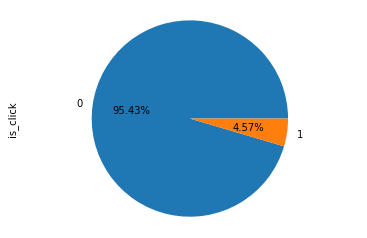

In [29]:
# Pie Plot to Visualise the Target Variable
label.value_counts().plot.pie(autopct='%1.2f%%')
plt.axis('equal')
plt.show()

- In the train dataset only 4.57% of the impressions were clicked

In [31]:
train[train.user_id == 63410]

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
4635,6b18886bc278247582704943f5c66eb9,2018-11-16 16:31:00,63410,467,latest,1,0
6088,cbd7fb1bba4de3486f76147a75f3ec89,2018-11-16 18:14:00,63410,467,latest,1,0
8851,0b6cf75f58aca50278bdcfc9c46576f4,2018-11-18 08:09:00,63410,467,latest,1,0
12204,9fd93cfddc3568482b5eb057efe06f16,2018-11-17 01:54:00,63410,467,latest,1,0
13964,5c7368d5679563a902701bf8b46575fc,2018-11-18 07:48:00,63410,283,latest,1,0
14779,c86027cb65669a6bec290bd22c969f2d,2018-11-19 02:04:00,63410,467,latest,1,0
19776,f0e52b27a7a5d6a1a87373dffa53dbe5,2018-11-15 00:56:00,63410,467,latest,1,0
21732,9a9fdbd56eb7c442646ab01c6bb3a70f,2018-11-20 09:08:00,63410,467,latest,1,0
26203,5e1982541fb01c50b6509e8ad3b5221c,2018-11-21 00:25:00,63410,467,latest,1,0


In [33]:
log[log.user_id == 63410]

,server_time,device_type,session_id,user_id,item_id
284024,2018-10-21 06:13:00,android,356854,63410,43209
284028,2018-10-21 06:13:00,android,356854,63410,66370
309046,2018-10-21 17:01:00,android,345289,63410,43209
339224,2018-10-22 09:54:00,android,406658,63410,43209
449354,2018-10-24 11:14:00,android,15568,63410,71877
486317,2018-10-25 05:00:00,android,343558,63410,43209
486325,2018-10-25 05:03:00,android,343558,63410,43209
2115995,2018-11-24 05:29:00,android,983607,63410,97274
3028698,2018-12-10 19:48:00,android,135003,63410,109074
3028895,2018-12-10 19:51:00,android,135003,63410,58018
